# LLM Classifications vs Currency Movement
## --- changes IP for more comprehensive approach, scroll down to bottom for info ---

investigated the relationship between LLM-generated classifications of news articles and subsequent currency movements. The analysis compares LLM classifications with actual exchange rate changes in the 10 minutes following each article's release.

**Goals:**
- Assess whether LLM sentiment classifications align with real-world currency movements.
- eval the predictive power of LLM outputs using confusion matrices.

---

## Experiment Overview
- **Data Source:** News articles and corresponding currency exchange rates.
- **LLM Used:** GPT-4 Turbo (commercial model)
- **Methodology:**
    1. Retrieve news articles and their release timestamps.
    2. Obtain currency exchange rates for the relevant pairs.
    3. Classify articles using the LLM.
    4. Analyze currency movement in the 10 minutes post-article release.
    5. Compare LLM predictions with actual currency movements.
- **Prompt.json**
    - zero-shot prompt (no labeled examples) found under prompts/prompt.json, no fine-tuning, just prompt-engineering used, based off macroeconomic and other influential factors in determining directional movement regarding exchange rates

## dates and times and exchange rates

## 1. Data Preparation

Load the necessary data and extract the relevant rows for analysis.

### Imports

In [5]:
import os
import sys
import pandas as pd

### Environment Setup

In [6]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(project_root)
sys.path.append(os.path.join(project_root, 'src'))

### Data

In [ ]:
llm_classifications_path = "data/processed/llm-classifications.csv"
df = pd.read_csv(llm_classifications_path)
rows = df['Row'].tolist()

## 2. Feature Engineering

Extract datetime values and corresponding exchange rates for each relevant news article row.

In [ ]:
from datetime import timedelta

def get_datetime_values(excel_file, row_indices):
    df = pd.read_excel(excel_file)
    datetime_dict = {}
    for idx in row_indices:
        row = df[df['Index'] == idx]
        if not row.empty:
            date = pd.to_datetime(row.iloc[0]['DATE'])
            time = pd.to_datetime(row.iloc[0]['TIME']).time()
            full_datetime = pd.Timestamp.combine(date, time)
            datetime_dict[idx] = {'datetime': full_datetime}
    return datetime_dict

def get_usdbrl_values_t_to_t10(exchange_file, datetime_dict):
    df = pd.read_excel(exchange_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)
    results = {}
    for index_val, dt in datetime_dict.items():
        base_time = dt['datetime']
        lookup_times = [base_time + timedelta(minutes=i) for i in range(11)]
        usdbrl_vals = {}
        for i, t in enumerate(lookup_times):
            label = f"t+{i}min" if i > 0 else "t"
            match = df[df['Date'] == t]
            usdbrl_vals[label] = match['USD/BRL'].values[0] if not match.empty else None
        results[index_val] = usdbrl_vals
    return results

### 2.1 Extract Datetime and Exchange Rate Values

Apply the feature engineering functions to obtain datetime and exchange rate values for each relevant row.

In [ ]:
corpus_path = "data/raw/allen-corpus.xlsx"
exchange_rates_path = "data/processed/exchange-rates.xlsx"
datetime_values = get_datetime_values(corpus_path, rows)
usdbrl_values = get_usdbrl_values_t_to_t10(exchange_rates_path, datetime_values)

In [6]:
# Display the extracted datetime and exchange rate values for verification
for idx, values in usdbrl_values.items():
    print(f"\nIndex {idx}:")
    
    base = values.get("t")
    if base is None:
        print("  Missing base value at t.")
        continue
    
    for i in range(1, 11):
        label = f"t+{i}min"
        val = values.get(label)
        
        if val is not None:
            direction = "increased" if val > base else "decreased" if val < base else "no change"
            print(f"  {label}: {direction}")
        else:
            print(f"  {label}: No data")


Index 6:
  t+1min: no change
  t+2min: increased
  t+3min: increased
  t+4min: increased
  t+5min: increased
  t+6min: increased
  t+7min: increased
  t+8min: increased
  t+9min: increased
  t+10min: increased

Index 8:
  t+1min: decreased
  t+2min: decreased
  t+3min: decreased
  t+4min: decreased
  t+5min: decreased
  t+6min: decreased
  t+7min: decreased
  t+8min: increased
  t+9min: increased
  t+10min: decreased

Index 10:
  t+1min: decreased
  t+2min: increased
  t+3min: decreased
  t+4min: decreased
  t+5min: decreased
  t+6min: decreased
  t+7min: decreased
  t+8min: decreased
  t+9min: decreased
  t+10min: decreased

Index 11:
  t+1min: no change
  t+2min: decreased
  t+3min: decreased
  t+4min: decreased
  t+5min: decreased
  t+6min: decreased
  t+7min: decreased
  t+8min: decreased
  t+9min: decreased
  t+10min: decreased

Index 12:
  t+1min: increased
  t+2min: increased
  t+3min: decreased
  t+4min: increased
  t+5min: increased
  t+6min: increased
  t+7min: increased
  t

## 3. Data Aggregation and Labeling

Create a results DataFrame and label the direction of currency movement numerically for each time increment.

In [ ]:
llm_dict = dict(zip(df['Row'], df['v1 Prompt']))
data = {
    'index': [],
    'llm_class': [],
    't+1min': [],
    't+2min': [],
    't+3min': [],
    't+4min': [],
    't+5min': [],
    't+6min': [],
    't+7min': [],
    't+8min': [],
    't+9min': [],
    't+10min': []
}
for idx, values in usdbrl_values.items():
    data['index'].append(idx)
    data['llm_class'].append(llm_dict[idx])
    base = values['t']
    for i in range(1, 11):
        col = f't+{i}min'
        val = values[col]
        if val > base:
            movement = -1
        elif val < base:
            movement = 1
        else:
            movement = 0
        data[col].append(movement)
results_df = pd.DataFrame(data)

In [ ]:
results_df

,index,llm_class,t+1min,t+2min,t+3min,t+4min,t+5min,t+6min,t+7min,t+8min,t+9min,t+10min
0,6,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,8,1,1,1,1,1,1,1,1,-1,-1,1
2,10,0,1,-1,1,1,1,1,1,1,1,1
3,11,0,0,1,1,1,1,1,1,1,1,1
4,12,-1,-1,-1,1,-1,-1,-1,-1,1,0,-1
5,13,-1,1,1,-1,1,1,1,1,1,-1,-1
6,14,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
7,16,-1,1,1,1,1,1,1,1,1,1,1
8,17,-1,1,1,1,1,1,1,1,1,1,-1
9,22,0,1,-1,-1,-1,-1,-1,-1,-1,1,1


## 4. Analysis and Evaluation

Analyze the relationship between LLM classifications and currency movement using confusion matrices for each time increment.

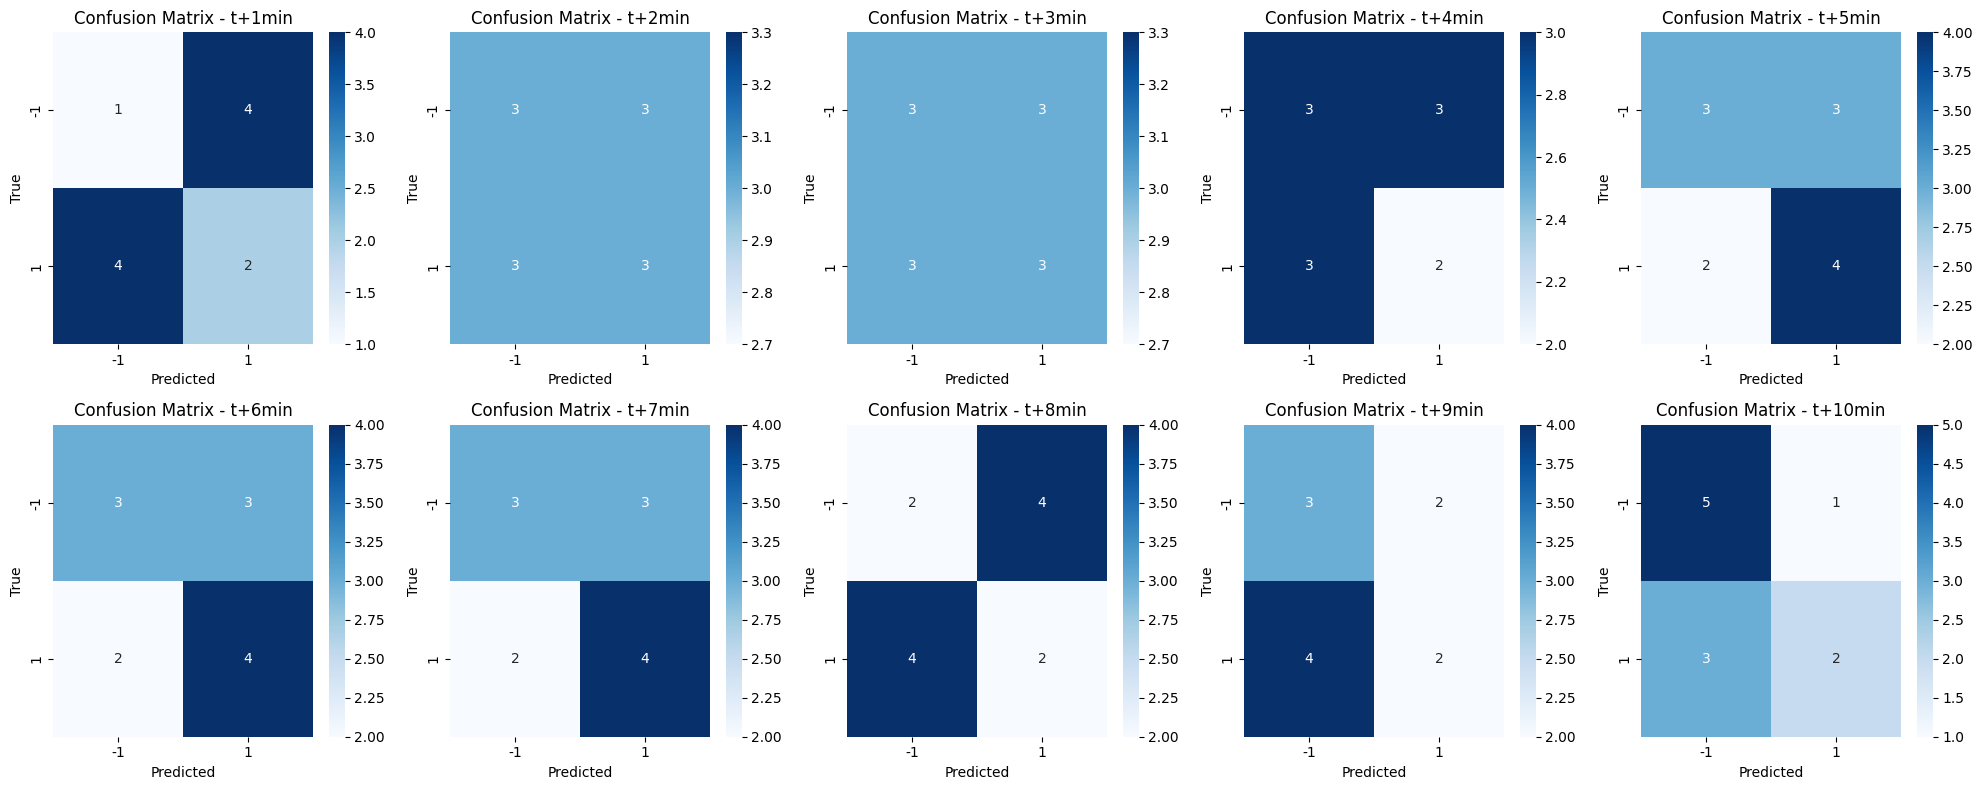

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
confusion_matrices = {}
for i in range(1, 11):
    time_col = f't+{i}min'
    filtered_df = results_df[results_df['llm_class'] != 0]
    filtered_df = filtered_df[filtered_df[time_col] != 0]
    if not filtered_df.empty:
        cm = confusion_matrix(
            filtered_df['llm_class'],
            filtered_df[time_col],
            labels=[-1, 1]
        )
        confusion_matrices[time_col] = cm
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, (time, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=[-1, 1], yticklabels=[-1, 1])
    axes[i].set_title(f'Confusion Matrix - {time}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
plt.tight_layout()
plt.show()

## 5. Results & Discussion

- The confusion matrices above show  relationship between LLM classifications and actual currency movements for each minute after news release.
- Analyze the matrices to assess predictive alignment and identify patterns.

**Next Steps:**
- change the entire thing. 25 article headlines is not enough. 
- possibly a complimentary approach of RAG and fine-tuning open-source Meta-LLaMA 7b model, might need compute, hopefully run first experiment locally
- "there are several scenarios in which RAG is not only not an alternative to fine-tuning, but also more of a complementary approach to fine-tuning" - https://ai.meta.com/blog/when-to-fine-tune-llms-vs-other-techniques/